In [1]:
import numpy as np
import sys
sys.path.append('../')
import pickle
import matplotlib.pyplot as plt
from scipy.stats import special_ortho_group
from src.Mondrian_matrix_utils import simulate
import pandas as pd
import jax.numpy as jnp
from jax import grad, vmap

dim_in = 5
active = 2
def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.0001):
    res = jnp.dot(x, rotation)
    projected = jnp.concatenate([jnp.ones(active), jnp.zeros(dim_in - active)])
    y = jnp.dot(res ** 4, projected)
    r_noise = np.random.RandomState(seed)
    #n = len(x)
    noise = r_noise.randn(1)[0] * jnp.sqrt(noise_sig2)
    y = y + noise
    return y


n = 2000
#rotation = pickle.load(open("rotation.pk", "rb"))
rotation = special_ortho_group.rvs(dim_in)
#print(rotation)
x_train = np.random.rand(n,dim_in)*2 - 1
y_train = simulate_y(x_train, rotation)

x_test = np.random.rand(5000,dim_in)*2 - 1
y_test = simulate_y(x_test, rotation)

sample_range = [2000]

In [2]:
M = 10                      # number of Mondrian trees to use
lifetime_max = 3          # terminal lifetime
weights_lifetime = 2*1e-6   # lifetime for which weights should be plotted
delta = 0.1              # ridge regression delta

In [3]:
W_grad = vmap(grad(simulate_y, argnums=0), in_axes=(0, None), out_axes=0)(x_train, rotation)
from numpy import linalg
from src.Mondrian_matrix_utils import two_one_norm
true_H = jnp.matmul(jnp.transpose(W_grad), W_grad) / n
true_H = true_H / two_one_norm(true_H)

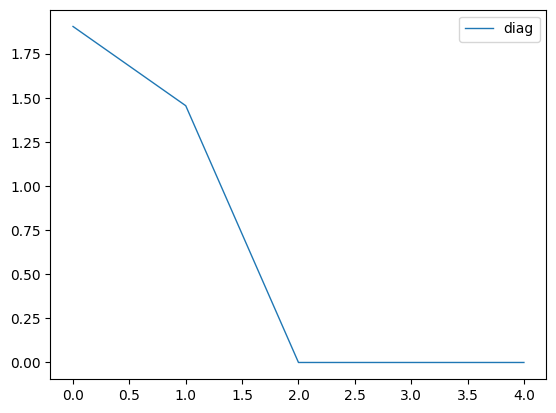

In [4]:
eigenvalues, eigenvectors = linalg.eig(true_H)
from src.Mondrian_matrix_utils import draw
draw(dim_in, eigenvalues)

In [5]:
def get_angle_distance(H, truth):
    dim_proj = active
    proj = np.identity(dim_proj)
    proj = np.pad(proj, [(0, dim_in - dim_proj), (0, dim_in - dim_proj)], mode='constant')
    
    _, eigenvectors = linalg.eig(H)
    Q_H, _ = linalg.qr(eigenvectors[:, :active])
    
    Q_t, _ = linalg.qr(truth[:, :active])

    D = np.matmul(np.transpose(Q_H), Q_t)
    U, S, Vh = np.linalg.svd(D, full_matrices=True)
    return np.arccos(S)

In [6]:
from src.Mondrian_matrix_utils import *
from sklearn.metrics import mean_squared_error
def train_and_evaluate(x_train, y_train, x_test, y_test, M, lifetime_max, delta):

    X_bd_all, X, history, w_kernel, y_hat_train = train(x_train, y_train, M, lifetime_max, delta, mondrian_kernel = True,
                                    weights_from_lifetime=weights_lifetime)
    _, y_hat_test = evaluate(x_train, y_train, x_test, M, delta, history, w_kernel, mondrian_kernel = True, 
                                    weights_from_lifetime=weights_lifetime)

    mse = mean_squared_error(y_test, y_hat_test)
    return mse, X_bd_all, X, history, w_kernel, y_hat_train

def estimate_H(x_train, y_train, X_bd_all, M, delta, X, history, w_kernel, y_hat_train):
    dim_in = X.shape[1]
    n = X.shape[0]
    importance = []
    for dim in range(dim_in):
        try:
            x_eval = None
            y_eval = []
            x_diff = []
            subset_all = []
            for tree in range(M):
                temp = X_bd_all[tree,dim] - X
                subset = temp[:,dim] != 0
                subset_all = subset_all + list(subset)
                
                if sum(subset) > 0:
                    if x_eval is None:
                        x_eval = X_bd_all[tree,dim][subset]
                    else:
                        x_eval = np.vstack((x_eval, X_bd_all[tree,dim][subset]))
                    y_eval = y_eval + y_hat_train[subset].tolist()
                    x_diff = x_diff + list(temp[:,dim][subset])
            
            _, y_hat_eval = evaluate(x_train, y_train, x_eval, M, delta, history, w_kernel, mondrian_kernel = True, 
                                    weights_from_lifetime=weights_lifetime)
            y_eval = np.array(y_eval)
            x_diff = np.array(x_diff)
            importance_temp = populate_importance(subset_all, ((y_eval - y_hat_eval)/x_diff))
            importance_temp = np.reshape(importance_temp, (len(X), M))
            importance_temp = np.median(importance_temp, axis = 1)
        except:
            importance_temp = np.zeros(len(X))
        importance.append(importance_temp)
    importance = np.vstack(importance)

    H = np.matmul(importance, np.transpose(importance))

    #eig = np.linalg.eig(H)[0]
    #y_diag = np.diagonal(H)
    #plot_spectrum(eig, y_diag, 'spectrum')
    return H

def transform_data(H, x_train, x_test):
    x_train_transformed = np.matmul(x_train, H)
    x_test_transformed = np.matmul(x_test, H)
    return x_train_transformed, x_test_transformed

In [7]:
from src.Mondrian_matrix_utils import *

def simulate_proj_H(x_train, y_train, x_test, y_test, M, lifetime_max, delta, weights_lifetime, H = None):
    x_train_transformed = np.matmul(x_train, H)
    x_test_transformed = np.matmul(x_test, H)
    _, _, history, w_kernel, _ = train(x_train_transformed, y_train, M, lifetime_max, delta, mondrian_kernel = True,
                                weights_from_lifetime=weights_lifetime)

    _, y_hat_test = evaluate(x_test_transformed, y_train, x_test_transformed, M, delta, history, w_kernel, mondrian_kernel = True, 
                                weights_from_lifetime=weights_lifetime)

    mse_best = mean_squared_error(y_test, y_hat_test)

    return mse_best

for lifetime in [0.1,0.5,1,2,3]:
    for n_sim in sample_range:
        for round in range(2):
            print(f"lifetime: {lifetime}")
            mse_best = simulate_proj_H(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime, delta, weights_lifetime, H = true_H)
            print(mse_best)

lifetime: 0.1
0.7889813
lifetime: 0.1
0.7964628
lifetime: 0.5
0.6652285
lifetime: 0.5
0.6527158
lifetime: 1
0.7001738
lifetime: 1
0.6867143
lifetime: 2
0.76336133
lifetime: 2
0.7586113
lifetime: 3
0.8013126
lifetime: 3
0.80156964


In [8]:
for lifetime in [0.1,0.5,1,2,3]:
    for n_sim in sample_range:
        print(f"lifetime: {lifetime}")
        mse, _, _, _, _, _ = train_and_evaluate(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime_max, delta)
        print(mse)

lifetime: 0.1
0.8718465
lifetime: 0.5
0.8703173
lifetime: 1
0.8718661
lifetime: 2
0.8689321
lifetime: 3
0.8699203


In [9]:
def experiment(x_train, y_train, x_test, y_test, M, lifetime_max, delta, H, full = True):
    mse, X_bd_all, X, history, w_kernel, y_hat_train = train_and_evaluate(x_train, y_train, x_test, y_test, M, lifetime_max, delta)
    H_itr = estimate_H(x_train, y_train, X_bd_all, M, delta, X, history, w_kernel, y_hat_train)
    if full:
        H = np.matmul(np.matmul(H, H_itr), H)
    else:
        H = np.matmul(H, H_itr)
    H = H / two_one_norm(H)
    return mse, H

In [10]:
stats = {}
for n_sim in sample_range:
    stats[n_sim] = []
    print(f"number of training samples: {n_sim}")
    for index in range(5):
        results = {'full': [], 'partial': []}
        mse, X_bd_all, X, history, w_kernel, y_hat_train = train_and_evaluate(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime_max, delta)
        H_0 = estimate_H(x_train[:n_sim, ], y_train[:n_sim], X_bd_all, M, delta, X, history, w_kernel, y_hat_train)
        H_0 = H_0 / two_one_norm(H_0)
        print(f"mse before:{mse}")


        print("full")
        results['full'].append(mse)
        x_train_transformed, x_test_transformed = transform_data(H_0, x_train[:n_sim, ], x_test)
        H = H_0
        lifetime = lifetime_max
        for reiterate in range(25):
            #print(get_angle_distance(H, true_H))
            mse, H = experiment(x_train_transformed, y_train[:n_sim],
                 x_test_transformed, y_test, M, lifetime, delta, H)
            print(mse)
            results['full'].append(mse)
            x_train_transformed, x_test_transformed = transform_data(H, x_train[:n_sim, ], x_test)
            lifetime -= 0.1
        
        stats[n_sim].append(results)

number of training samples: 2000
mse before:0.8702487349510193
full
0.8673143
0.85369045
0.84130204
0.8319961
0.8263761
0.84315234
0.8560369
0.8557103
0.85716546
0.8543002
0.8587246
0.85358495
0.85420674
0.85341114
0.85126877
0.8511322
0.8522562
0.85262287
0.8504073
0.84759843
0.8499289
0.853491
0.846699
0.8462045
0.8467041
mse before:0.8711313605308533
full
0.86683035
0.85780126
0.8452301
0.83114046
0.80627626
0.76696384
0.7587171
0.752071
0.7465325
0.7367203
0.73980826
0.7445748
0.7277731
0.744995
0.7379292
0.72935367
0.73000157
0.72785586
0.72256994
0.709338
0.70405203
0.70301366
0.69783574
0.7118645
0.6998365
mse before:0.8720525503158569
full
0.87000585
0.86399865
0.84542
0.828642
0.8214339
0.7998884
0.81761444
0.82561994
0.8351419
0.82799315
0.8276502
0.8234954
0.82274914
0.82354367
0.82314265
0.82121426
0.8177306
0.8146152
0.8138276
0.81073207
0.80958253
0.80878115
0.8017147
0.8055886
0.80479276
mse before:0.8708611130714417
full
0.8666082
0.8609254
0.847834
0.8216871
0.8184761


In [11]:
begin_mse, _, _, _, _, _ = train_and_evaluate(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, 3, delta)
mse_nothing, _, _, _, _, _ = train_and_evaluate(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, 1, delta)
mse_best = simulate_proj_H(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, 1, delta, weights_lifetime, H = true_H)
mse_sub_best = simulate_proj_H(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, 3, delta, weights_lifetime, H = true_H)

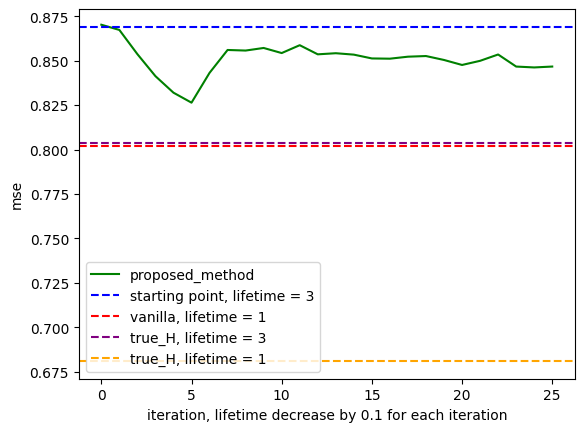

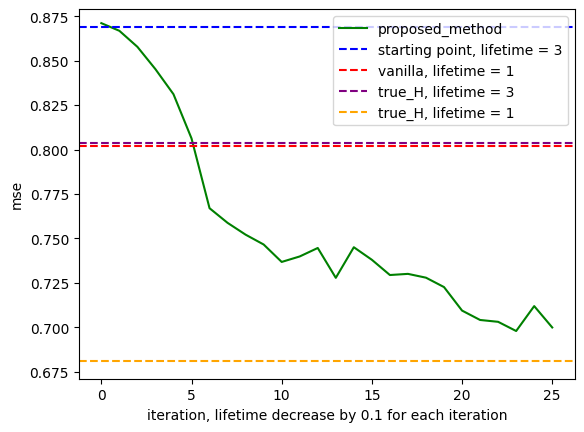

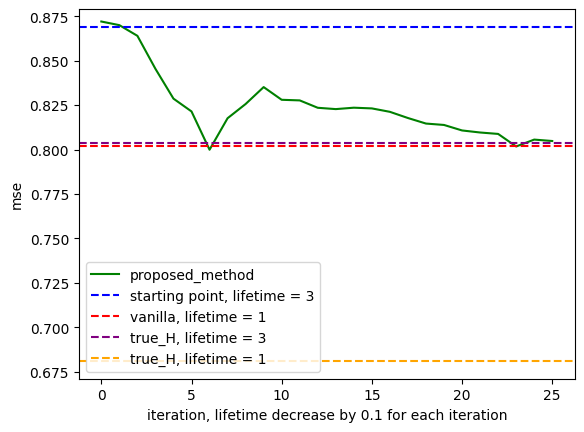

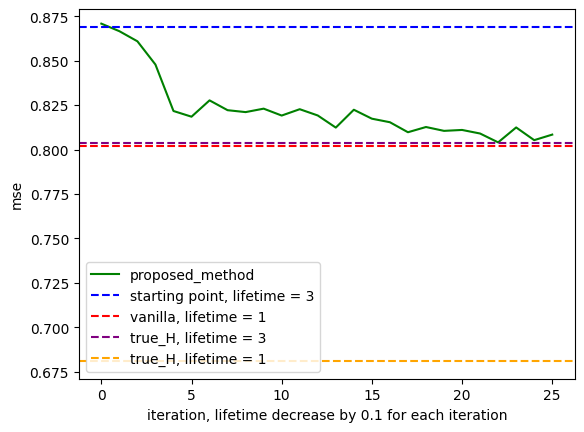

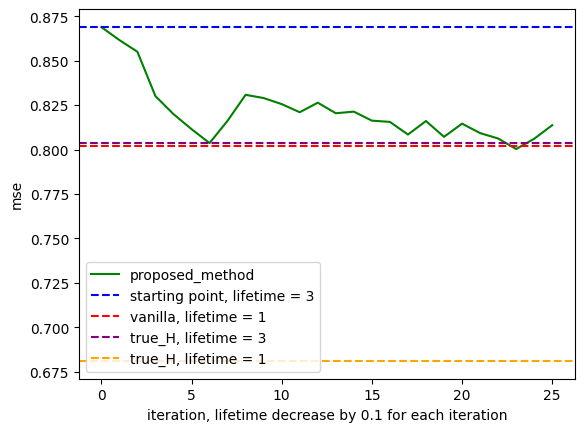

In [12]:
x = list(range(26))

for tries in range(5):
    fig, ax = plt.subplots()
    ax.set_ylim(mse_best-0.01, begin_mse+0.01)  # 
    ax.plot(x, stats[2000][tries]['full'], color='g', label='proposed_method')
    ax.axhline(y=begin_mse, color='b', linestyle='--', label='starting point, lifetime = 3')
    ax.axhline(y=mse_nothing, color='r', linestyle='--', label='vanilla, lifetime = 1')
    ax.axhline(y=mse_sub_best, color='purple', linestyle='--', label='true_H, lifetime = 3')
    ax.axhline(y=mse_best, color='orange', linestyle='--', label='true_H, lifetime = 1')
    ax.set_xlabel("iteration, lifetime decrease by 0.1 for each iteration")
    ax.set_ylabel("mse")
    ax.legend()